# 🎥 Abnormality Detection in Videos using CNN

This notebook implements a CNN-based pipeline for detecting abnormal events in videos.
We will:
- Build the CNN model step by step
- Test each layer/block with dummy data
- Clearly comment and visualize each transformation

🗂 Datasets used (preprocessed):
- Avenue
- UCSD Ped1 and Ped2
- Violent Flows

Each frame is:
- Grayscale (1 channel)
- Resized to **200×200**
- Labeled: 0 (normal), 1 (anomalous or violent)

We start with model construction.


In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cpu


## 🧠 CNN Model: Convolution + Activation + Pooling Layers

We begin building our CNN with two convolutional blocks. Each block consists of:

- A 2D Convolution layer with a kernel size of **3×3** and **64 filters**.
- A **ReLU** activation function.
- A **MaxPooling layer** with a pool size of **2×2** to reduce dimensionality.

These layers help the model extract both **low-level features** (edges, lines) and **high-level abstract features** (shapes, regions of movement).

---

### 📐 Mathematical Operation of Convolution

The convolution of an image $I$ with a filter $F$ is defined as:

$$
C(x, y) = \sum_{m} \sum_{n} I(m, n) \cdot F(x - m, y - n)
$$

Where:

- $F$: 2D filter (kernel)  
- $I$: input image  
- $(x,y), (m,n)$: pixel positions  

---

### 🚶 Stride
Stride is the step size by which the filter moves across the image. In this model, we use **stride = 1**. It ensures more detailed feature extraction.

---

### ⚡ Activation Function

We use the **ReLU** function for intermediate layers, which is defined as:

$$
ReLU(x) = \max(0, x)
$$

For the output layer, we use **Sigmoid** (for binary classification):

$$
Sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

---


In [2]:
class ConvBlock1(nn.Module):
    def __init__(self):
        super(ConvBlock1, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.block(x)


## 🧠 Conv Block 2

This block takes the 64 feature maps output from Conv Block 1 and applies a second round of feature extraction.

### Layer Details:
- **Input**: [64, 100, 100]
- **Conv2D**: 64 filters of size 3×3, padding=1
- **Activation**: ReLU
- **Pooling**: MaxPool with 2×2 kernel and stride 2 → reduces dimensions

📐 After this block:
- Input: [64, 100, 100]
- Output: [64, 50, 50]


In [3]:
class ConvBlock2(nn.Module):
    def __init__(self):
        super(ConvBlock2, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.block(x)


In [4]:
conv1 = ConvBlock1().to(device)

dummy_input = torch.randn(1, 1, 200, 200).to(device)

output_conv1 = conv1(dummy_input)

print("Shape after Conv Block 1:", output_conv1.shape)


Shape after Conv Block 1: torch.Size([1, 64, 100, 100])


In [5]:
conv2 = ConvBlock2().to(device)

output_conv2 = conv2(output_conv1)

print("Shape after Conv Block 2:", output_conv2.shape)


Shape after Conv Block 2: torch.Size([1, 64, 50, 50])


## 🎨 Visualizing CNN Feature Maps

To understand how our convolutional blocks process input frames, we visualize intermediate feature maps.

Each **filter** in a CNN learns to detect specific features such as:
- Edges
- Textures
- Motion regions (later layers)

We visualize a few feature maps from:
1. **Conv Block 1** output: [1, 64, 100, 100]
2. **Conv Block 2** output: [1, 64, 50, 50]


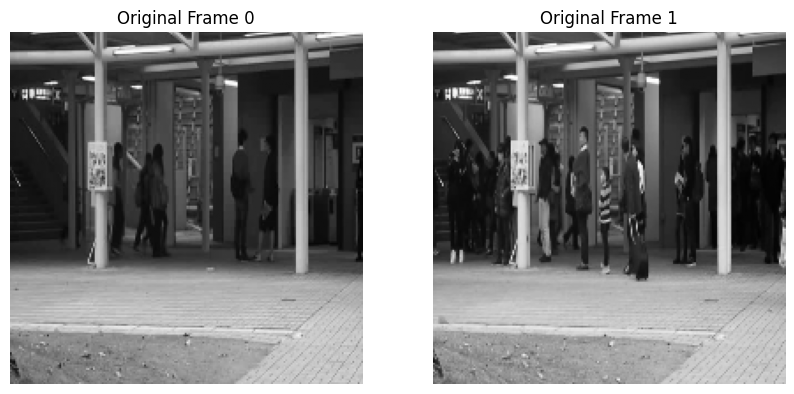

In [9]:
from PIL import Image
import torch
from torchvision import transforms

frame_paths = [
    'data/avenue/train_frames/01/frame_0000.png',
    'data/avenue/train_frames/16/frame_0002.png'
]

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((200, 200)),
    transforms.ToTensor() 
])

images = [transform(Image.open(p)) for p in frame_paths]
input_batch = torch.stack(images)
input_batch.shape
def show_images(batch, title=""):
    fig, axs = plt.subplots(1, len(batch), figsize=(10, 5))
    for i, img in enumerate(batch):
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].set_title(f"{title} {i}")
        axs[i].axis('off')
    plt.show()

show_images(input_batch, title="Original Frame")


## Step 2: First CNN Layer (Conv + ReLU + MaxPool)

This layer applies a convolution operation with 64 filters of size 3×3, followed by ReLU activation and a 2×2 Max Pooling. We test this on our input batch.


In [10]:
conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
relu = nn.ReLU()
pool = nn.MaxPool2d(kernel_size=2, stride=2)

x1 = conv1(input_batch)
x1_relu = relu(x1)
x1_pool = pool(x1_relu)

print("Conv Block 1 output:", x1_pool.shape)


Conv Block 1 output: torch.Size([2, 64, 100, 100])


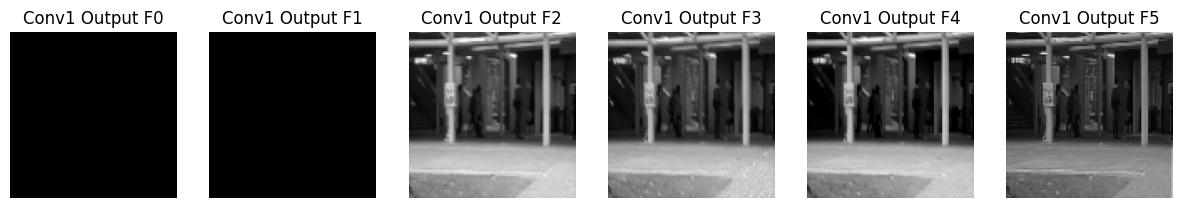

In [11]:
def visualize_feature_maps(tensor, frame_idx=0, n_maps=6, title=""):
    maps = tensor[frame_idx].detach().cpu()
    fig, axs = plt.subplots(1, n_maps, figsize=(15, 5))
    for i in range(n_maps):
        axs[i].imshow(maps[i], cmap='gray')
        axs[i].set_title(f"{title} F{i}")
        axs[i].axis('off')
    plt.show()

visualize_feature_maps(x1_pool, frame_idx=0, title="Conv1 Output")


### 🔍 Conv Block 2

Another 3×3 convolution with 64 filters, followed by ReLU and 2×2 max pooling.


Conv Block 2 output: torch.Size([2, 64, 50, 50])


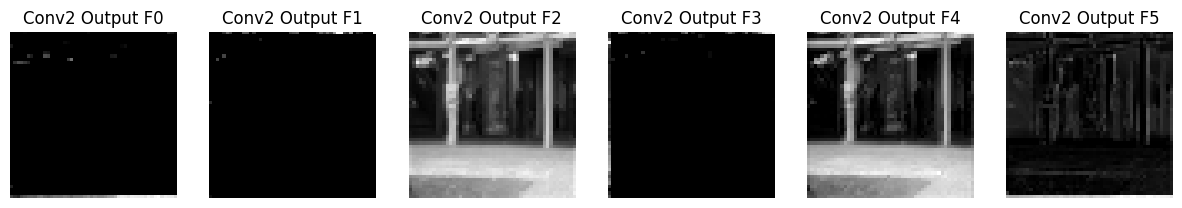

In [12]:
conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

x2 = conv2(x1_pool)
x2_relu = relu(x2)
x2_pool = pool(x2_relu)

print("Conv Block 2 output:", x2_pool.shape)
visualize_feature_maps(x2_pool, frame_idx=0, title="Conv2 Output")


In [13]:
x_flat = x2_pool.view(x2_pool.size(0), -1)
fc1 = nn.Linear(x_flat.shape[1], 128)
fc2 = nn.Linear(128, 1)

x_fc1 = relu(fc1(x_flat))
x_out = torch.sigmoid(fc2(x_fc1))

print("Prediction Probabilities:", x_out.squeeze().detach().numpy())


Prediction Probabilities: [0.50054544 0.4985184 ]


### 🔄 Flatten Layer

Converts the 3D feature maps into 1D vectors to pass into the fully connected layers.


In [18]:
x_out = x_out.view(x_out.size(0), -1)
print("Flattened shape:", x_out.shape)


Flattened shape: torch.Size([2, 1])


### 💡 Fully Connected Layer 1 + ReLU

Reduces dimensionality to 128 with a fully connected layer and applies ReLU activation.


In [20]:
fc1 = nn.Linear(x_out.shape[1], 128)
x_out = relu(fc1(x_out))
print("FC1 output shape:", x_out.shape)


FC1 output shape: torch.Size([2, 128])


### 💡 Fully Connected Layer 2 + Sigmoid

Reduces to a single output neuron and applies a sigmoid to output binary class probability.


In [21]:
fc2 = nn.Linear(128, 1)
x = torch.sigmoid(fc2(x_out))
print("Final output shape:", x.shape)
print("Binary predictions:", x.detach().numpy())


Final output shape: torch.Size([2, 1])
Binary predictions: [[0.52053344]
 [0.5206912 ]]
